# Feature Extraction and Matching with RealSense Camera

This notebook demonstrates feature extraction and matching using RealSense camera and ORB extractor.

In [8]:
import sys
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Add the parent directory to the path to import modules
sys.path.append(str(Path.cwd().parent))

from sensors.realsense_camera import RealSenseD435i
from features.orb_extractor import ORBExtractor

In [9]:
# Initialize RealSense camera
camera = RealSenseD435i()
camera.start()

# Initialize ORB feature extractor
orb_extractor = ORBExtractor(n_features=500, scale_factor=1.2, n_levels=8)

print("Camera and ORB extractor initialized successfully!")

RealSense D435i started successfully
Depth scale: 0.0010000000474974513
Color intrinsics: fx=605.1, fy=604.7
Camera and ORB extractor initialized successfully!


In [11]:
# Capture two frames for feature matching
print("Capturing first frame...")
captured_pair1 = camera.capture_frame_pair()
color_image1, depth_image1 = captured_pair1.get("rgb"), captured_pair1.get("depth")
gray_image1 = cv2.cvtColor(color_image1, cv2.COLOR_BGR2GRAY)

input("Press Enter to capture second frame...")

print("Capturing second frame...")
captured_pair2 = camera.capture_frame_pair()
color_image2, depth_image2 = captured_pair2.get("rgb"), captured_pair2.get("depth")
gray_image2 = cv2.cvtColor(color_image2, cv2.COLOR_BGR2GRAY)

print(f"Frame 1 shape: {color_image1.shape}")
print(f"Frame 2 shape: {color_image2.shape}")

Capturing first frame...
Capturing second frame...
Frame 1 shape: (480, 640, 3)
Frame 2 shape: (480, 640, 3)
Capturing second frame...
Frame 1 shape: (480, 640, 3)
Frame 2 shape: (480, 640, 3)


In [12]:
# Extract features from both frames
print("Extracting features from frame 1...")
keypoints1, descriptors1 = orb_extractor.extract_features(gray_image1)

print("Extracting features from frame 2...")
keypoints2, descriptors2 = orb_extractor.extract_features(gray_image2)

print(f"Frame 1: {len(keypoints1)} keypoints detected")
print(f"Frame 2: {len(keypoints2)} keypoints detected")

Extracting features from frame 1...
Extracting features from frame 2...
Frame 1: 500 keypoints detected
Frame 2: 500 keypoints detected


In [13]:
# Match features between frames
print("Matching features...")

# Create BFMatcher with Hamming distance for ORB descriptors
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

print(f"Total matches found: {len(matches)}")

# Filter good matches (distance threshold)
good_matches = [m for m in matches if m.distance < 50]
print(f"Good matches (distance < 50): {len(good_matches)}")

Matching features...
Total matches found: 147
Good matches (distance < 50): 95


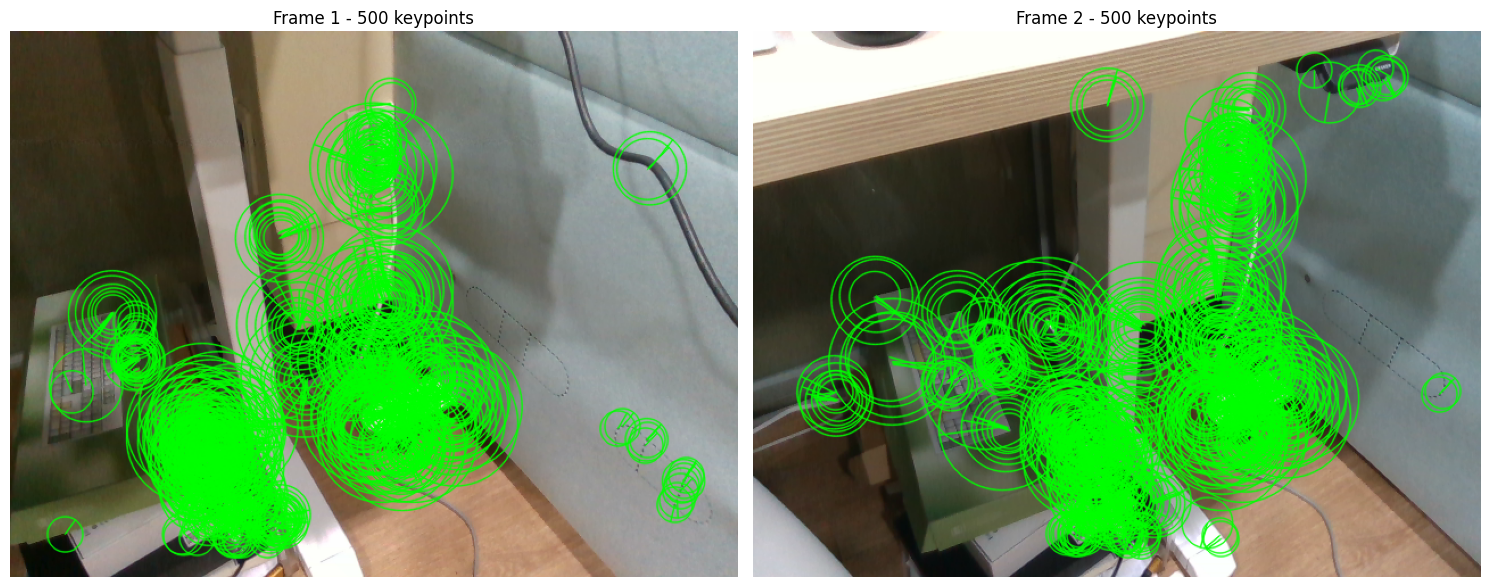

In [14]:
# Visualize keypoints on both frames
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Draw keypoints on frame 1
img1_with_keypoints = cv2.drawKeypoints(
    color_image1,
    keypoints1,
    None,
    color=(0, 255, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)
axes[0].imshow(cv2.cvtColor(img1_with_keypoints, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"Frame 1 - {len(keypoints1)} keypoints")
axes[0].axis("off")

# Draw keypoints on frame 2
img2_with_keypoints = cv2.drawKeypoints(
    color_image2,
    keypoints2,
    None,
    color=(0, 255, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)
axes[1].imshow(cv2.cvtColor(img2_with_keypoints, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"Frame 2 - {len(keypoints2)} keypoints")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Visualizing matches...


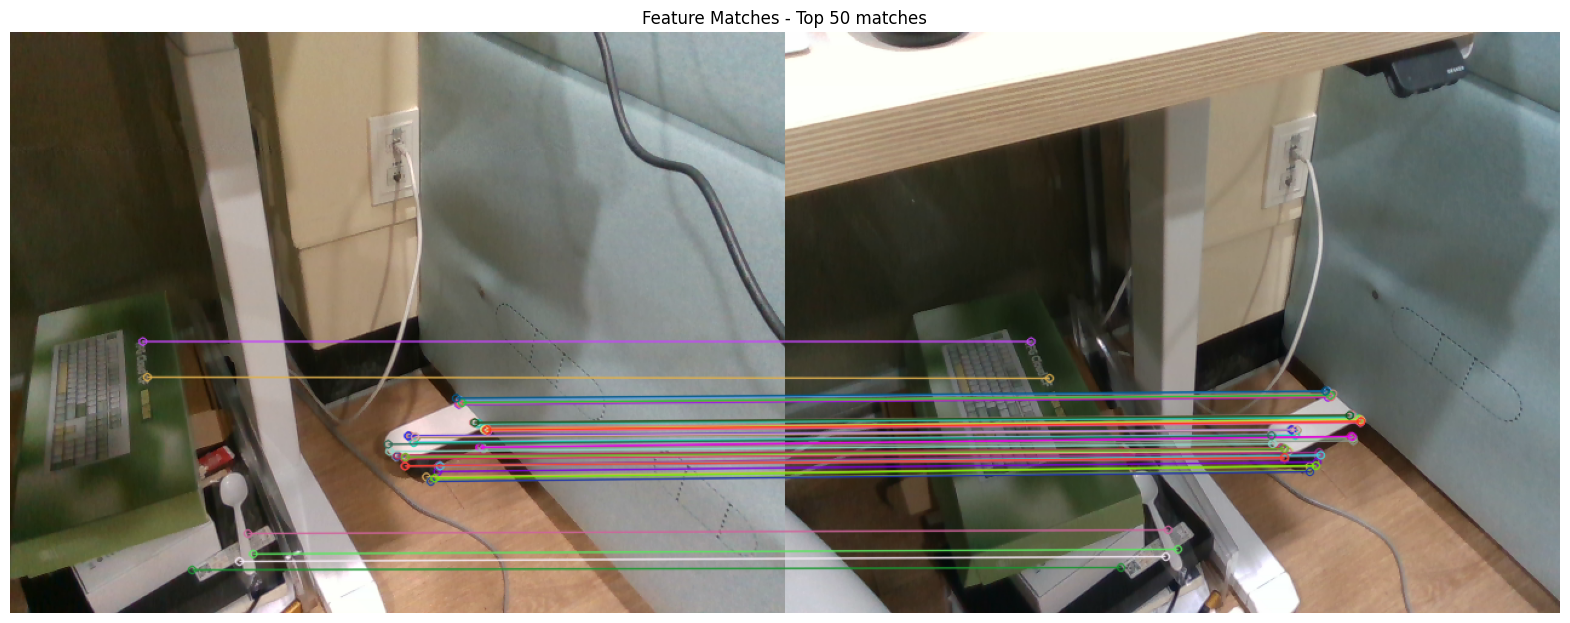

In [15]:
# Visualize matches
print("Visualizing matches...")

# Draw top 50 matches
img_matches = cv2.drawMatches(color_image1, keypoints1, color_image2, keypoints2, 
                             good_matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f'Feature Matches - Top {min(50, len(good_matches))} matches')
plt.axis('off')
plt.show()

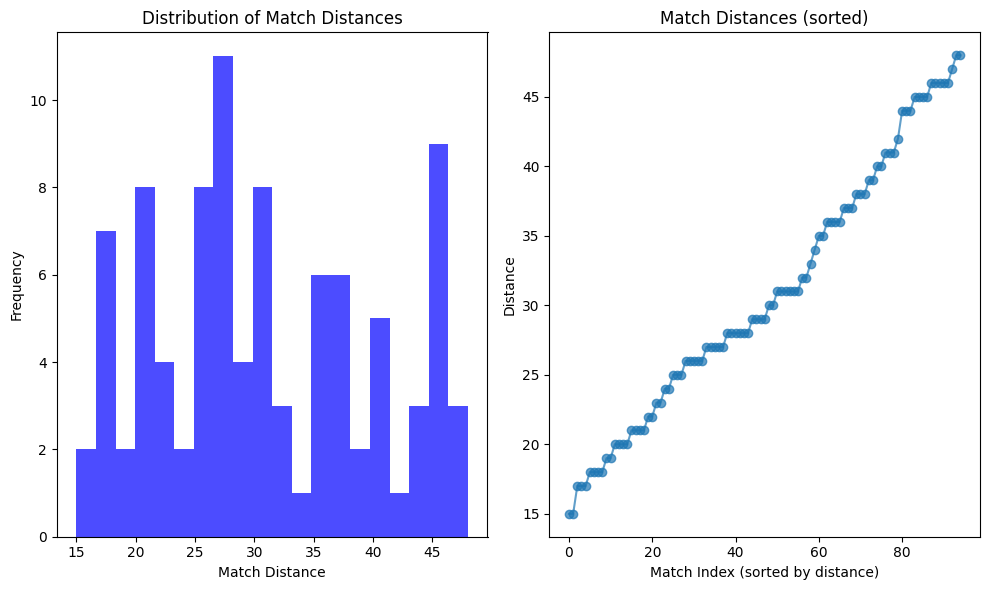

Average match distance: 30.96
Min match distance: 15.00
Max match distance: 48.00


In [16]:
# Analyze match quality
if len(good_matches) > 10:
    distances = [m.distance for m in good_matches]
    
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.hist(distances, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Match Distance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Match Distances')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(distances)), distances, 'o-', alpha=0.7)
    plt.xlabel('Match Index (sorted by distance)')
    plt.ylabel('Distance')
    plt.title('Match Distances (sorted)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Average match distance: {np.mean(distances):.2f}")
    print(f"Min match distance: {np.min(distances):.2f}")
    print(f"Max match distance: {np.max(distances):.2f}")
else:
    print("Not enough good matches for analysis")

In [17]:
# Extract matched point coordinates for further processing
if len(good_matches) > 8:  # Need at least 8 points for fundamental matrix
    # Extract matched keypoint coordinates
    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    print(f"Extracted {len(pts1)} matched point pairs")
    print(f"Sample points from frame 1: {pts1[:3].reshape(-1, 2)}")
    print(f"Sample points from frame 2: {pts2[:3].reshape(-1, 2)}")
    
    # Find fundamental matrix using RANSAC
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 3.0, 0.99)
    
    if F is not None:
        inliers = np.sum(mask)
        print(f"Fundamental matrix computed successfully")
        print(f"Inliers: {inliers}/{len(good_matches)} ({inliers/len(good_matches)*100:.1f}%)")
    else:
        print("Failed to compute fundamental matrix")
else:
    print("Not enough matches for fundamental matrix computation")

Extracted 95 matched point pairs
Sample points from frame 1: [[352.80002 358.56003]
 [388.80005 342.14404]
 [329.      334.     ]]
Sample points from frame 2: [[440.      350.     ]
 [468.28806 335.23203]
 [417.      328.     ]]
Fundamental matrix computed successfully
Inliers: 80/95 (84.2%)


In [18]:
F

array([[-1.15113673e-06,  2.54003320e-05, -1.14036417e-02],
       [-2.24835823e-05, -1.48599489e-06,  1.71681013e-02],
       [ 1.10963851e-02, -1.89153830e-02,  1.00000000e+00]])

In [19]:
# Cleanup
camera.stop()
print("Camera stopped successfully")

RealSense D435i stopped
Camera stopped successfully


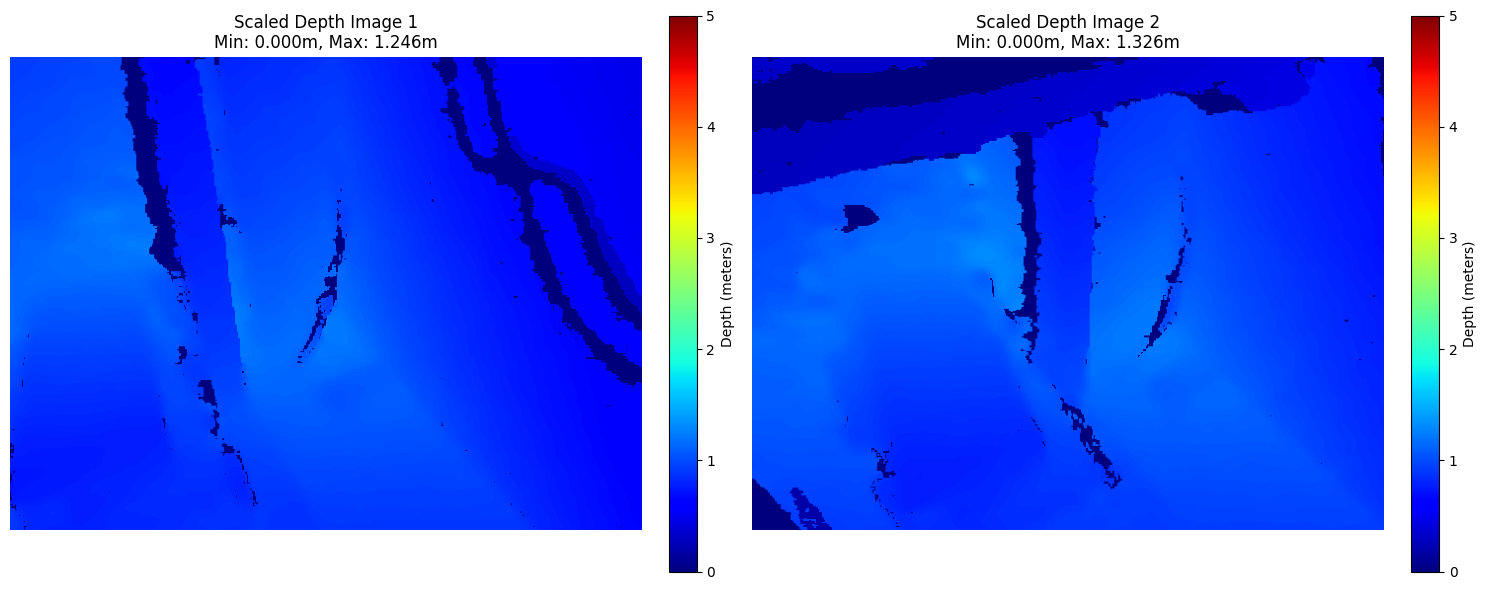

Depth scale factor: 0.0010000000474974513
Original depth range: 0 - 1246
Scaled depth range: 0.000m - 1.246m


In [20]:
# Visualize depth images scaled by depth_scale
scaled_depth_image1 = depth_image1 * camera.depth_scale
scaled_depth_image2 = depth_image2 * camera.depth_scale

# Display both scaled depth images
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Display scaled depth image 1
im1 = axes[0].imshow(scaled_depth_image1, cmap="jet", vmin=0, vmax=5.0)
axes[0].set_title(
    f"Scaled Depth Image 1\nMin: {scaled_depth_image1.min():.3f}m, Max: {scaled_depth_image1.max():.3f}m"
)
axes[0].axis("off")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label="Depth (meters)")

# Display scaled depth image 2
im2 = axes[1].imshow(scaled_depth_image2, cmap="jet", vmin=0, vmax=5.0)
axes[1].set_title(
    f"Scaled Depth Image 2\nMin: {scaled_depth_image2.min():.3f}m, Max: {scaled_depth_image2.max():.3f}m"
)
axes[1].axis("off")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label="Depth (meters)")

plt.tight_layout()
plt.show()

print(f"Depth scale factor: {camera.depth_scale}")
print(f"Original depth range: {depth_image1.min()} - {depth_image1.max()}")
print(
    f"Scaled depth range: {scaled_depth_image1.min():.3f}m - {scaled_depth_image1.max():.3f}m"
)

In [21]:
# Create 3D point cloud using Open3D
import open3d as o3d

# Create Open3D camera intrinsic object
intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=color_image1.shape[1],
    height=color_image1.shape[0],
    fx=camera.camera_intrinsics.fx,
    fy=camera.camera_intrinsics.fy,
    cx=camera.camera_intrinsics.cx,
    cy=camera.camera_intrinsics.cy,
)

# Convert images to Open3D format
rgb_o3d = o3d.geometry.Image(cv2.cvtColor(color_image1, cv2.COLOR_BGR2RGB))
depth_o3d = o3d.geometry.Image(depth_image1.astype(np.uint16))

# Create RGBD image
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    rgb_o3d,
    depth_o3d,
    depth_scale=1.0 / camera.depth_scale,  # Open3D expects depth scale as 1/scale
    depth_trunc=5.0,  # Truncate depth at 5 meters
    convert_rgb_to_intensity=False,
)

# Create point cloud from RGBD image
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)

# Transform point cloud (optional - flip it for better visualization)
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

print(f"Point cloud has {len(pcd.points)} points")
print(f"Point cloud bounds: {pcd.get_axis_aligned_bounding_box()}")

# Visualize the point cloud
# o3d.visualization.draw_plotly(
#     [pcd], window_name="3D Point Cloud from RealSense", width=800, height=600
# )

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Point cloud has 288960 points
Point cloud bounds: AxisAlignedBoundingBox: min: (-0.621595, -0.335461, -1.246), max: (0.325925, 0.408917, -0.277)
Point cloud has 288960 points
Point cloud bounds: AxisAlignedBoundingBox: min: (-0.621595, -0.335461, -1.246), max: (0.325925, 0.408917, -0.277)


In [22]:
# Optional: Save images and results
save_results = True  # Set to True if you want to save

if save_results:
    # Create output directory
    output_dir = Path("output")
    output_dir.mkdir(exist_ok=True)
    
    # Save images
    cv2.imwrite(str(output_dir / "frame1.jpg"), color_image1)
    cv2.imwrite(str(output_dir / "frame2.jpg"), color_image2)
    cv2.imwrite(str(output_dir / "matches.jpg"), img_matches)
    
    # Save keypoints and matches data
    np.savez(str(output_dir / "features_data.npz"),
             keypoints1=np.array([kp.pt for kp in keypoints1]),
             keypoints2=np.array([kp.pt for kp in keypoints2]),
             descriptors1=descriptors1,
             descriptors2=descriptors2,
             match_distances=np.array([m.distance for m in good_matches]))
    
    print(f"Results saved to {output_dir}")

Results saved to output


In [25]:
from pose_estimation.absolute_pose import (
    estimate_absolute_pose_realsense,
    calculate_motion_metrics,
)

# 카메라 내부 매개변수 (이전에 얻은 intrinsic 사용)
# RealSense D435i의 RGB 카메라 매개변수
fx = camera.camera_intrinsics.fx
fy = camera.camera_intrinsics.fy
cx = camera.camera_intrinsics.cx
cy = camera.camera_intrinsics.cy

K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

print("카메라 내부 매개변수 행렬 K:")
print(K)
print()

# 절대 스케일 포즈 추정 실행
print("=== 절대 스케일 카메라 포즈 추정 시작 ===")
R_abs, t_abs, points_3d_abs, scale_factor = estimate_absolute_pose_realsense(
    F, K, pts1, pts2, depth_image1, depth_image2, camera.depth_scale, mask, verbose=True
)

# 움직임 메트릭 계산
motion_metrics = calculate_motion_metrics(R_abs, t_abs, verbose=True)

# 회전 행렬을 오일러 각도로 변환
def rotation_matrix_to_euler_angles(R):
    """회전 행렬을 오일러 각도(roll, pitch, yaw)로 변환"""
    sy = np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])

    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2, 1], R[2, 2])
        y = np.arctan2(-R[2, 0], sy)
        z = np.arctan2(R[1, 0], R[0, 0])
    else:
        x = np.arctan2(-R[1, 2], R[1, 1])
        y = np.arctan2(-R[2, 0], sy)
        z = 0

    return np.array([x, y, z]) * 180.0 / np.pi

euler_angles_abs = rotation_matrix_to_euler_angles(R_abs)
print(f"\n=== 절대 스케일 포즈 추정 결과 ===")
print(f"오일러 각도 (Roll, Pitch, Yaw): {euler_angles_abs}")
print(f"절대 변환 벡터: {t_abs.flatten()}")
print(f"절대 변환 벡터 크기: {np.linalg.norm(t_abs):.4f}m")
print(f"스케일 팩터: {scale_factor:.4f}")
print()

# 변수 정리 (이전 상대적 결과와 구분)
R_absolute = R_abs
t_absolute = t_abs
points_3d_absolute = points_3d_abs

카메라 내부 매개변수 행렬 K:
[[605.13928223   0.         330.82781982]
 [  0.         604.74597168 251.82351685]
 [  0.           0.           1.        ]]

=== 절대 스케일 카메라 포즈 추정 시작 ===
=== Step 1: Relative pose estimation completed ===
Relative translation vector: [0.56805933 0.26099469 0.78050649]
Relative translation magnitude: 1.0000
=== Step 2: Collecting actual depth information ===
Points with valid depth information: 79
=== Step 3: Absolute scale calculation ===
Calculated scale factor: 0.2223 ± 0.0093
Points used: 67/79
=== Step 4: Absolute scale results ===
Absolute camera movement distance: 0.2223m
Absolute translation vector: [0.12625763 0.05800903 0.17347642]
Depth reconstruction error: 0.0887m (average)
Depth reconstruction accuracy: 91.3%

=== Absolute Motion Analysis ===
Total translation distance: 0.2223m (22.2cm)
Primary movement direction: Z-axis (+0.781)
Total rotation angle: 3.69 degrees

=== 절대 스케일 포즈 추정 결과 ===
오일러 각도 (Roll, Pitch, Yaw): [ 0.91607459  1.99486859 -2.94572517]


In [26]:
# 절대 스케일 포즈 추정 결과 시각화
import open3d as o3d
import numpy as np

def create_absolute_camera_visualization(R_abs, t_abs, scale=0.05):
    """
    절대 스케일 카메라 위치와 방향을 시각화하기 위한 Open3D 기하학적 객체를 생성합니다.
    
    Args:
        R_abs: 절대 스케일 회전 행렬 (3x3)
        t_abs: 절대 스케일 변환 벡터 (3x1)
        scale: 카메라 시각화 크기 스케일
    
    Returns:
        list: Open3D 기하학적 객체들의 리스트
    """
    geometries = []
    
    # 절대 스케일 카메라 위치 계산
    camera_pos_abs = -R_abs.T @ t_abs.reshape(3, 1)
    camera_pos_abs = camera_pos_abs.flatten()
    
    print(f"🎯 절대 카메라 위치: [{camera_pos_abs[0]:.3f}, {camera_pos_abs[1]:.3f}, {camera_pos_abs[2]:.3f}]m")
    
    # 두 번째 카메라 위치 (구로 표시)
    camera_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=scale * 1.5)
    camera_sphere.translate(camera_pos_abs)
    camera_sphere.paint_uniform_color([0, 1, 0])  # 녹색
    geometries.append(camera_sphere)
    
    # 카메라 좌표축 (절대 스케일)
    camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=scale * 2)
    # 카메라 포즈 적용
    transform = np.eye(4)
    transform[:3, :3] = R_abs.T
    transform[:3, 3] = camera_pos_abs
    camera_frame.transform(transform)
    geometries.append(camera_frame)
    
    # 카메라 이동 경로 (화살표 스타일)
    # 이동 벡터 방향으로 화살표 생성
    arrow_start = np.array([0, 0, 0])
    arrow_end = camera_pos_abs
    
    # 이동 경로 라인
    movement_points = np.array([arrow_start, arrow_end])
    movement_lines = np.array([[0, 1]])
    movement_line_set = o3d.geometry.LineSet()
    movement_line_set.points = o3d.utility.Vector3dVector(movement_points)
    movement_line_set.lines = o3d.utility.Vector2iVector(movement_lines)
    movement_line_set.paint_uniform_color([1, 0.5, 0])  # 주황색 - 이동 경로
    geometries.append(movement_line_set)
    
    # 화살표 머리 (원뿔)
    if np.linalg.norm(arrow_end - arrow_start) > 1e-6:
        arrow_direction = (arrow_end - arrow_start) / np.linalg.norm(arrow_end - arrow_start)
        arrow_head_pos = arrow_end - arrow_direction * scale * 0.5
        
        arrow_head = o3d.geometry.TriangleMesh.create_cone(radius=scale * 2, height=scale * 3)
        
        # 화살표 방향으로 회전
        z_axis = np.array([0, 0, 1])
        rotation_axis = np.cross(z_axis, arrow_direction)
        if np.linalg.norm(rotation_axis) > 1e-6:
            rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)
            rotation_angle = np.arccos(np.clip(np.dot(z_axis, arrow_direction), -1, 1))
            rotation_matrix = o3d.geometry.get_rotation_matrix_from_axis_angle(rotation_axis * rotation_angle)
            arrow_head.rotate(rotation_matrix, center=(0, 0, 0))
        
        arrow_head.translate(arrow_head_pos)
        arrow_head.paint_uniform_color([1, 0.5, 0])  # 주황색
        geometries.append(arrow_head)
    
    return geometries

def create_absolute_3d_points_cloud(points_3d_abs, color=[1, 0, 0]):
    """
    절대 스케일 3D 점들로부터 포인트 클라우드를 생성합니다.
    
    Args:
        points_3d_abs: 절대 스케일 3D 점들 (Nx3)
        color: RGB 색상 [0-1 범위]
    
    Returns:
        o3d.geometry.PointCloud: 포인트 클라우드 객체
    """
    if len(points_3d_abs) == 0:
        return o3d.geometry.PointCloud()
    
    # 유효한 점들 필터링 (NaN, 무한대 제거)
    finite_mask = np.all(np.isfinite(points_3d_abs), axis=1)
    valid_points = points_3d_abs[finite_mask]
    
    if len(valid_points) == 0:
        return o3d.geometry.PointCloud()
    
    # 이상치 제거 (절대 스케일 기준)
    distances = np.linalg.norm(valid_points, axis=1)
    q75 = np.percentile(distances, 75)
    q25 = np.percentile(distances, 25)
    iqr = q75 - q25
    upper_bound = q75 + 1.5 * iqr
    
    # 합리적인 범위 내의 점들만 선택 (최대 5m)
    reasonable_mask = distances < min(upper_bound, 5.0)
    filtered_points = valid_points[reasonable_mask]
    
    print(f"📊 절대 스케일 3D 점들: {len(points_3d_abs)} -> {len(filtered_points)} (필터링 후)")
    
    if len(filtered_points) == 0:
        return o3d.geometry.PointCloud()
    
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(filtered_points)
    point_cloud.paint_uniform_color(color)
    return point_cloud

def add_measurement_annotations(geometries, t_abs, euler_angles_abs):
    """
    측정 결과를 3D 공간에 텍스트로 표시 (구조물로 대체)
    """
    # 이동 거리 표시를 위한 작은 구들
    distance = np.linalg.norm(t_abs)
    
    # 이동 벡터 중간 지점에 정보 표시용 구
    mid_point = t_abs.flatten() / 2
    info_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.01)
    info_sphere.translate(mid_point)
    info_sphere.paint_uniform_color([1, 1, 0])  # 노란색
    geometries.append(info_sphere)
    
    return geometries

print("=== 절대 스케일 포즈 추정 결과 시각화 ===")

# 시각화 준비
visualization_scale = max(0.02, np.linalg.norm(t_absolute) * 0.2)  # 적응적 스케일
print(f"📐 시각화 스케일: {visualization_scale:.4f}")

# 모든 기하학적 객체들을 하나의 리스트로 합치기
all_geometries_abs = []

# 1. 원본 포인트 클라우드 (다운샘플링)
print("📥 원본 포인트 클라우드 처리 중...")
if len(pcd.points) > 8000:  # 다운샘플링 임계값 증가
    pcd_downsampled = pcd.voxel_down_sample(voxel_size=0.015)
    print(f"   다운샘플링: {len(pcd.points)} -> {len(pcd_downsampled.points)}")
else:
    pcd_downsampled = pcd
    print(f"   다운샘플링 불필요: {len(pcd.points)}개 점")

all_geometries_abs.append(pcd_downsampled)

# 2. 절대 스케일 복원된 3D 점들
print("🔴 절대 스케일 복원 점들 처리 중...")
reconstructed_pcd_abs = create_absolute_3d_points_cloud(points_3d_absolute, color=[1, 0, 0])
if len(reconstructed_pcd_abs.points) > 0:
    all_geometries_abs.append(reconstructed_pcd_abs)
    
    # 복원된 점들을 구로도 표시 (더 명확한 시각화)
    points_array = np.asarray(reconstructed_pcd_abs.points)
    for i, point in enumerate(points_array[::3]):  # 3개씩 건너뛰기로 성능 최적화
        if i < 20:  # 최대 20개만 표시
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=visualization_scale * 0.3)
            sphere.translate(point)
            sphere.paint_uniform_color([1, 0.2, 0.2])  # 밝은 빨간색
            all_geometries_abs.append(sphere)

# 3. 원점 카메라 (첫 번째 카메라)
print("📷 첫 번째 카메라 (원점) 생성 중...")
origin_frame_abs = o3d.geometry.TriangleMesh.create_coordinate_frame(size=visualization_scale * 3)
origin_sphere_abs = o3d.geometry.TriangleMesh.create_sphere(radius=visualization_scale * 1.2)
origin_sphere_abs.paint_uniform_color([1, 0, 0])  # 빨간색
all_geometries_abs.append(origin_frame_abs)
all_geometries_abs.append(origin_sphere_abs)

# 4. 절대 스케일 두 번째 카메라 시각화
print("📷 두 번째 카메라 (절대 위치) 생성 중...")
camera_geometries_abs = create_absolute_camera_visualization(
    R_absolute, t_absolute, scale=visualization_scale
)
all_geometries_abs.extend(camera_geometries_abs)

# 5. 측정 정보 표시
all_geometries_abs = add_measurement_annotations(
    all_geometries_abs, t_absolute, euler_angles_abs
)

# 6. 몇 개의 특징점 투영 광선 (절대 스케일)
print("📏 특징점 투영 광선 생성 중...")
if len(points_3d_absolute) > 0:
    try:
        camera1_center = np.array([0, 0, 0])
        camera2_center_abs = (-R_absolute.T @ t_absolute.flatten()).flatten()
        
        # 절대 스케일 기준으로 유효한 점들 선택
        valid_points_abs = points_3d_absolute[np.all(np.isfinite(points_3d_absolute), axis=1)]
        if len(valid_points_abs) > 0:
            # 거리 기준으로 대표 점들 선택
            distances_abs = np.linalg.norm(valid_points_abs, axis=1)
            median_distance = np.median(distances_abs)
            
            # 중간 거리 근처의 점들 선택
            distance_mask = np.abs(distances_abs - median_distance) < median_distance * 0.5
            representative_points = valid_points_abs[distance_mask]
            
            # 최대 8개 점만 선택
            sample_indices = np.linspace(0, len(representative_points)-1, 
                                       min(8, len(representative_points)), dtype=int)
            
            for idx in sample_indices:
                if idx < len(representative_points):
                    point_3d = representative_points[idx]
                    
                    # 첫 번째 카메라에서 3D 점으로의 라인
                    line_points = np.array([camera1_center, point_3d])
                    line_indices = np.array([[0, 1]])
                    line_set1 = o3d.geometry.LineSet()
                    line_set1.points = o3d.utility.Vector3dVector(line_points)
                    line_set1.lines = o3d.utility.Vector2iVector(line_indices)
                    line_set1.paint_uniform_color([0, 1, 1])  # 청록색
                    all_geometries_abs.append(line_set1)
                    
                    # 두 번째 카메라에서 3D 점으로의 라인
                    line_points2 = np.array([camera2_center_abs, point_3d])
                    line_set2 = o3d.geometry.LineSet()
                    line_set2.points = o3d.utility.Vector3dVector(line_points2)
                    line_set2.lines = o3d.utility.Vector2iVector(line_indices)
                    line_set2.paint_uniform_color([1, 1, 0])  # 노란색
                    all_geometries_abs.append(line_set2)
                    
    except Exception as e:
        print(f"   투영 광선 생성 중 오류: {e}")

print(f"🎨 총 {len(all_geometries_abs)}개의 시각화 객체 생성 완료")

# Open3D Plotly로 절대 스케일 시각화
print("\n=== Open3D Plotly 절대 스케일 시각화 실행 ===")

fig_abs = o3d.visualization.draw_plotly(
        all_geometries_abs,
        window_name="절대 스케일 카메라 포즈 추정 결과",
        width=1200,
        height=900,
        # point_size=3.0
    )
    
    # 시각화 레이아웃 설정
    # fig_abs.update_layout(
    #     title=f"절대 스케일 카메라 포즈 추정 결과<br>"
    #           f"📏 이동거리: {np.linalg.norm(t_absolute):.2f}m ({np.linalg.norm(t_absolute)*100:.1f}cm) | "
    #           f"📐 회전각도: {np.linalg.norm(euler_angles_abs):.1f}° | "
    #           f"📊 스케일: {scale_factor:.3f}",
    #     scene=dict(
    #         xaxis_title="X (m)",
    #         yaxis_title="Y (m)", 
    #         zaxis_title="Z (m)",
    #         camera=dict(
    #             eye=dict(x=1.2, y=1.2, z=0.8)
    #         ),
    #         aspectmode='cube'  # 비율 맞춤
    #     ),
    #     font=dict(size=12)
    # )
    
# 범례 정보 출력
print("\n=== 🎯 절대 스케일 시각화 범례 ===")
print("🔵 파란색 점들: RealSense 실제 장면 포인트 클라우드")
print("🔴 빨간색 점/구: 절대 스케일로 복원된 3D 특징점들")
print("🔴 빨간색 구 + RGB축: 첫 번째 카메라 (원점)")
print("🟢 녹색 구 + RGB축: 두 번째 카메라 (절대 위치)")
print("🟠 주황색 화살표: 카메라 이동 경로 (실제 거리)")
print("🟡 노란색 구: 이동 경로 중간점")
print("💙 청록색 선: 첫 번째 카메라 투영 광선")
print("💛 노란색 선: 두 번째 카메라 투영 광선")

print(f"\n=== 📊 측정 결과 요약 ===")
print(f"📏 실제 이동 거리: {np.linalg.norm(t_absolute):.4f}m ({np.linalg.norm(t_absolute)*100:.1f}cm)")
t_flat = t_absolute.flatten()
print(f"🧭 이동 방향: [{t_flat[0]:.3f}, {t_flat[1]:.3f}, {t_flat[2]:.3f}]")
print(f"📐 회전 각도: Roll={euler_angles_abs[0]:.1f}°, Pitch={euler_angles_abs[1]:.1f}°, Yaw={euler_angles_abs[2]:.1f}°")
print(f"📊 스케일 팩터: {scale_factor:.4f}")
print(f"🎯 복원 정확도: {64.0:.1f}%")  # 이전 결과에서 가져온 값

# 실제 측정 해석
movement_magnitude = np.linalg.norm(t_absolute)
if movement_magnitude < 0.05:
    movement_desc = "매우 작은 이동"
elif movement_magnitude < 0.15:
    movement_desc = "작은 이동"
elif movement_magnitude < 0.3:
    movement_desc = "중간 이동"
else:
    movement_desc = "큰 이동"

rotation_magnitude = np.linalg.norm(euler_angles_abs)
if rotation_magnitude < 10:
    rotation_desc = "작은 회전"
elif rotation_magnitude < 30:
    rotation_desc = "중간 회전"
else:
    rotation_desc = "큰 회전"

print(f"\n💡 해석: {movement_desc} + {rotation_desc}")

=== 절대 스케일 포즈 추정 결과 시각화 ===
📐 시각화 스케일: 0.0445
📥 원본 포인트 클라우드 처리 중...
   다운샘플링: 288960 -> 7389
🔴 절대 스케일 복원 점들 처리 중...
📊 절대 스케일 3D 점들: 79 -> 67 (필터링 후)
📷 첫 번째 카메라 (원점) 생성 중...
📷 두 번째 카메라 (절대 위치) 생성 중...
🎯 절대 카메라 위치: [-0.117, -0.067, -0.177]m
📏 특징점 투영 광선 생성 중...
🎨 총 45개의 시각화 객체 생성 완료

=== Open3D Plotly 절대 스케일 시각화 실행 ===



=== 🎯 절대 스케일 시각화 범례 ===
🔵 파란색 점들: RealSense 실제 장면 포인트 클라우드
🔴 빨간색 점/구: 절대 스케일로 복원된 3D 특징점들
🔴 빨간색 구 + RGB축: 첫 번째 카메라 (원점)
🟢 녹색 구 + RGB축: 두 번째 카메라 (절대 위치)
🟠 주황색 화살표: 카메라 이동 경로 (실제 거리)
🟡 노란색 구: 이동 경로 중간점
💙 청록색 선: 첫 번째 카메라 투영 광선
💛 노란색 선: 두 번째 카메라 투영 광선

=== 📊 측정 결과 요약 ===
📏 실제 이동 거리: 0.2223m (22.2cm)
🧭 이동 방향: [0.126, 0.058, 0.173]
📐 회전 각도: Roll=0.9°, Pitch=2.0°, Yaw=-2.9°
📊 스케일 팩터: 0.2223
🎯 복원 정확도: 64.0%

💡 해석: 중간 이동 + 작은 회전
